In [6]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pickle

In [2]:
import os 
os.makedirs('data', exist_ok=True)

In [3]:
# create data object
def build_samples(gvariant_status, edge, cancer):
    edge_index = torch.tensor(edge, dtype=torch.long)  # shape [2, num_edges]
    samples = []
    for i in range(gvariant_status.shape[0]):
        x_i = torch.tensor(gvariant_status[i], dtype=torch.float32).unsqueeze(1)  # [4384, 1]
        y_i = torch.tensor([cancer[i]], dtype=torch.long)
        data = Data(x=x_i, edge_index=edge_index, y=y_i)
        samples.append(data)
    return samples
    
# Define GAT model
class GATGraphClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True)
        self.gat2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False)
        self.pool = global_mean_pool
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index))
        x = self.pool(x, batch)
        return self.fc(x)

    def get_node_embeddings(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index))
        return x

# Compute node-level perturbation impact per sample
def compute_node_impact_matrix(samples, model):
    model.eval()
    with torch.no_grad():
        ref_x = torch.zeros((samples[0].num_nodes, 1), dtype=torch.float32)
        ref_edge_index = samples[0].edge_index
        ref_embedding = model.get_node_embeddings(ref_x, ref_edge_index)

        impact_matrix = []
        for sample in samples:
            emb = model.get_node_embeddings(sample.x, sample.edge_index)
            impact = torch.norm(emb - ref_embedding, dim=1)
            impact_matrix.append(impact.cpu().numpy())
    return np.array(impact_matrix)

# Train function
def train(model, loader, optimizer, criterion, epoch, save_embeddings=False):
    model.train()
    total_loss = 0
    for i, batch in enumerate(loader):
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch).squeeze()
        loss = criterion(out, batch.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        #if save_embeddings and i == 0:
        #    embeddings = model.get_node_embeddings(batch.x, batch.edge_index).detach().cpu().numpy()
        #    node_scores = batch.x.cpu().numpy()
        #    np.save(f'./data/epoch_{epoch}_train_embeddings.npy', embeddings)
        #    np.save(f'./data/epoch_{epoch}_train_node_scores.npy', node_scores)

    return total_loss / len(loader)

# Evaluate function
def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for batch in loader:
            out = model(batch.x, batch.edge_index, batch.batch).squeeze()
            prob = torch.sigmoid(out)
            pred = (prob > 0.5).long()
            y_true.extend(batch.y.tolist())
            y_pred.extend(pred.tolist())
            y_prob.extend(prob.tolist())
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return acc, auc, precision, recall, f1, fpr, tpr, y_pred, y_prob

# Run cross validation with ROC and loss tracking
def run_cross_validation(samples, in_channels, hidden_channels=32, epochs=100, folds=5, task = None):
    labels = [data.y.item() for data in samples]
    kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

    fold_results = []

    for fold, (train_idx, test_idx) in enumerate(kfold.split(samples, labels)):
        print(f"\n===== Fold {fold+1} =====")
        train_dataset = [samples[i] for i in train_idx]
        test_dataset = [samples[i] for i in test_idx]
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32)

        model = GATGraphClassifier(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=1)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
        criterion = torch.nn.BCEWithLogitsLoss()

        losses = []

        for epoch in range(1, epochs + 1):
            loss = train(model, train_loader, optimizer, criterion, epoch, save_embeddings=True)
            losses.append(loss)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}: Loss = {loss:.4f}")

        acc, auc, precision, recall, f1, fpr, tpr, y_pred, y_prob = evaluate(model, test_loader)
        print(f"Fold {fold+1} - Accuracy: {acc:.4f}, AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        fold_results.append((acc, auc, precision, recall, f1, fpr, tpr, y_pred, y_prob))

        # Plot training loss
        plt.figure()
        plt.plot(range(1, epochs+1), losses, label=f'Train Loss Fold {fold+1}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training Loss Fold {fold+1}')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC Fold {fold+1} (AUC = {auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve Fold {fold+1}')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

        # Visualize node embeddings for first graph in test set
        test_sample = test_dataset[0]
        embeddings = model.get_node_embeddings(test_sample.x, test_sample.edge_index).detach().cpu().numpy()
        tsne = TSNE(n_components=2, random_state=42)
        emb_2d = tsne.fit_transform(embeddings)

        plt.figure(figsize=(6, 6))
        plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=test_sample.x.squeeze().numpy(), cmap='coolwarm', s=10)
        plt.title(f'TSNE of Node Embeddings (Fold {fold+1}')
        plt.xlabel('Dim 1')
        plt.ylabel('Dim 2')
        plt.colorbar(label='Input Variant')
        plt.grid(True)
        plt.show()

        # save node importance
        impact_matrix_train = compute_node_impact_matrix(train_dataset, model)
        impact_matrix_test = compute_node_impact_matrix(test_dataset, model)
        np.save(f'./data/{task}_Fold{fold}_train_impact_matrix.npy', impact_matrix_train)
        np.save(f'./data/{task}_Fold{fold}_test_impact_matrix.npy', impact_matrix_test)
        

    mean_acc = sum([a for a, _, _, _, _, _, _, _, _ in fold_results]) / folds
    mean_auc = sum([a for _, a, _, _, _, _, _, _, _ in fold_results]) / folds
    mean_precision = sum([a for _, _, a, _, _, _, _, _, _ in fold_results]) / folds
    mean_recall = sum([a for _, _, _, a, _, _, _, _, _ in fold_results]) / folds
    mean_f1 = sum([a for _, _, _, _, a, _, _, _, _ in fold_results]) / folds

    print(f"\nMean Accuracy: {mean_acc:.4f}, Mean AUC: {mean_auc:.4f}, Mean Precision: {mean_precision:.4f}, Mean Recall: {mean_recall:.4f}, Mean F1: {mean_f1:.4f}")

    # Save the results with pickle
    with open('./data/brca_vs_skcm_prediction_results.pkl', 'wb') as f:
        pickle.dump(fold_results, f)

    return fold_results

In [4]:
germline_input = np.load('./data/tcga_germlinevariants_7861patients.npy', allow_pickle= True).item()
germline_input.keys()

dict_keys(['gvariant_status', 'gene', 'edge', 'age', 'patients', 'cancer'])

In [7]:
pd.Series(germline_input['cancer']).value_counts()>300

BRCA     True
LGG      True
HNSC     True
SKCM     True
PRAD     True
LUAD     True
UCEC     True
LUSC     True
OV       True
GBM      True
BLCA     True
THCA     True
KIRC     True
STAD    False
SARC    False
COAD    False
KIRP    False
CESC    False
LIHC    False
PAAD    False
PCPG    False
TGCT    False
ESCA    False
THYM    False
READ    False
MESO    False
ACC     False
KICH    False
UVM     False
UCS     False
CHOL    False
DLBC    False
Name: count, dtype: bool

In [8]:
gcancer = ['BRCA','OV','LGG','PRAD','LUSC','THCA','BLCA','LUSC','LUAD','COAD']
scancer = ['STAD','SKCM','GBM']

In [ ]:
output_all = {}

for g in gcancer:
    for s in scancer:
        cancer_index = np.where(pd.Series(germline_input['cancer']) == g)
        control_index = np.where(pd.Series(germline_input['cancer']) == s)
        all_index = np.concatenate((cancer_index[0], control_index[0]))
        
        g_input = np.concatenate((germline_input['gvariant_status'][cancer_index],germline_input['gvariant_status'][control_index]),axis = 0)
        edge_input = germline_input['edge']
        label = [1] * len(cancer_index[0]) + [0] * len(control_index[0]) 
        
        input_object = build_samples(g_input, 
                        edge_input, 
                        label)

        output = run_cross_validation(input_object, in_channels=1, epochs=100, folds = 5)

        output_all[f'{g}_vs_{s}'] = output

/tmp/ipykernel_13675/4283110946.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge, dtype=torch.long)  # shape [2, num_edges]



===== Fold 1 =====


In [ ]:
np.save('./data/final_prediction_results.npy', output_all, allow_pickle=True)

In [220]:
#x = torch.tensor(ginput_brca, dtype=torch.float)
#edge_index = edge_brca
#data = Data(x=x, edge_index=edge_index)
#data.y = torch.tensor([label], dtype=torch.float) 

/tmp/ipykernel_26213/2652066617.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge, dtype=torch.long)  # shape [2, num_edges]



===== Fold 1 =====
Epoch 10: Loss = 0.3622
Epoch 20: Loss = 0.3509
Fold 1 - Accuracy: 0.8662, AUC: 0.9179, Precision: 0.8848, Recall: 0.9084, F1: 0.8964


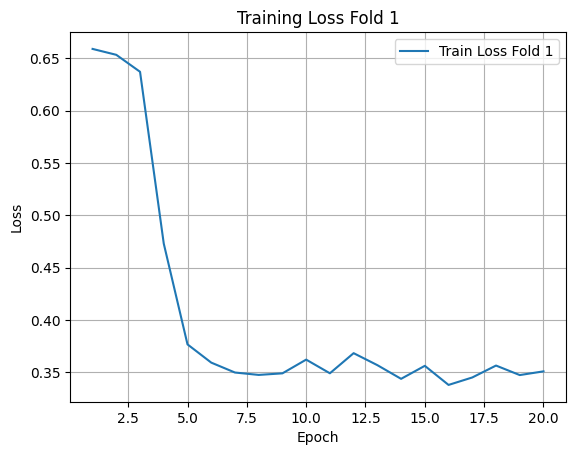

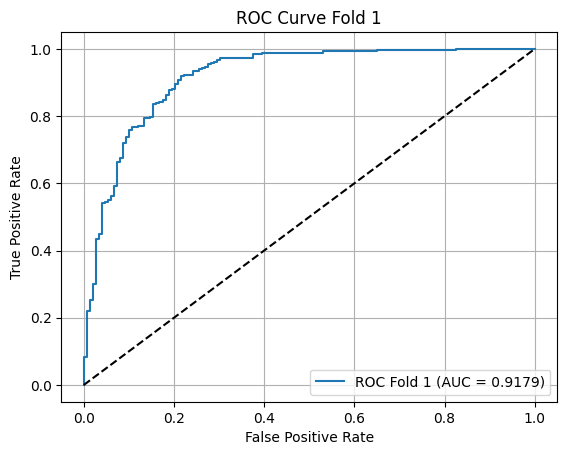

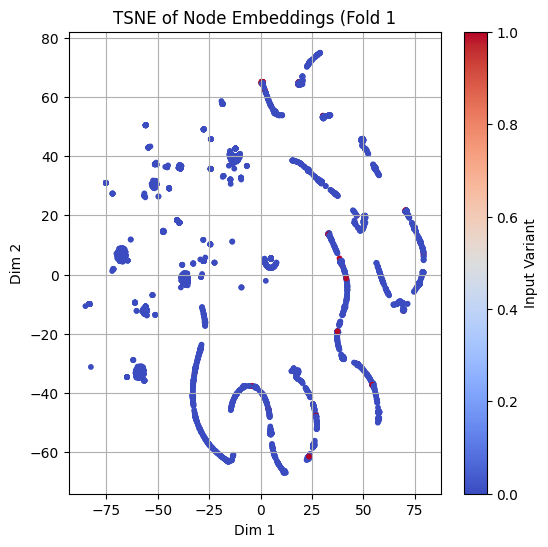


===== Fold 2 =====
Epoch 10: Loss = 0.3425
Epoch 20: Loss = 0.3773
Fold 2 - Accuracy: 0.8610, AUC: 0.9184, Precision: 0.9016, Recall: 0.8774, F1: 0.8893


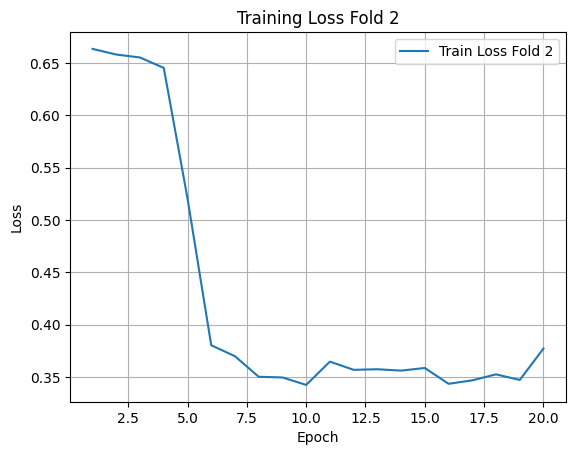

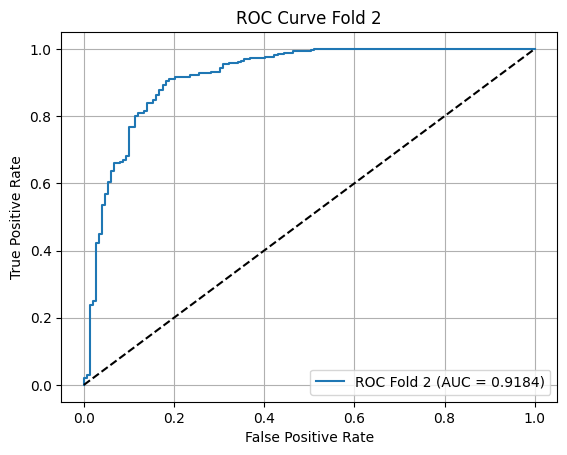

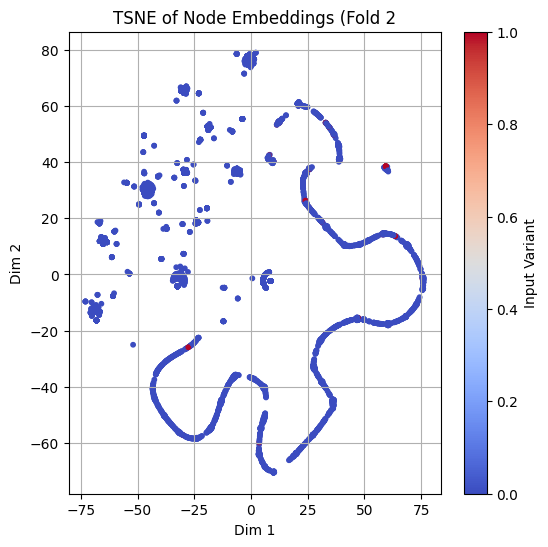


===== Fold 3 =====
Epoch 10: Loss = 0.3634
Epoch 20: Loss = 0.3539
Fold 3 - Accuracy: 0.8561, AUC: 0.9219, Precision: 0.8769, Recall: 0.9004, F1: 0.8885


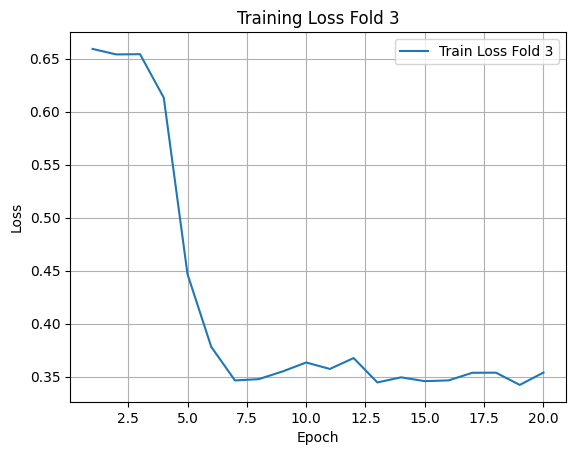

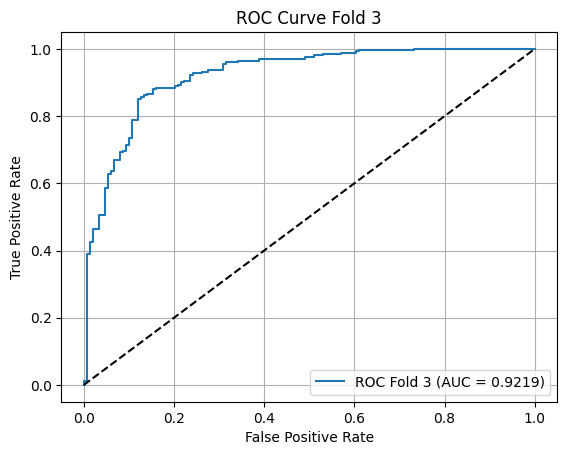

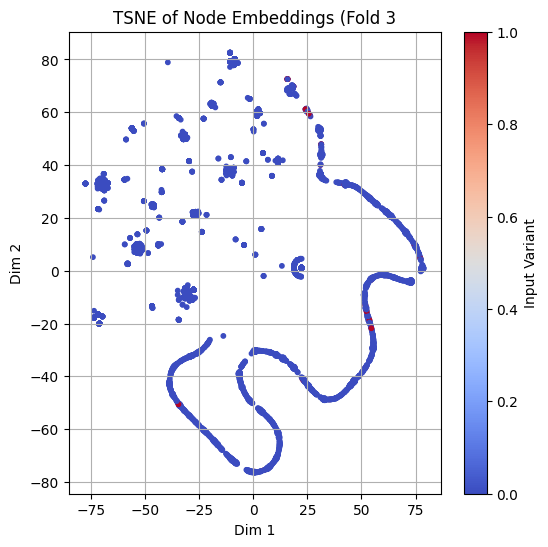


Mean Accuracy: 0.8611, Mean AUC: 0.9194, Mean Precision: 0.8877, Mean Recall: 0.8954, Mean F1: 0.8914


In [184]:
'''tmp = build_samples(ginput_brca, 
                    germline_input['edge'], 
                    label)

output = run_cross_validation(tmp, in_channels=1, epochs=20, folds = 3)